In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
def expand_array(short_array):
    long_array = np.zeros(6084)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(78) * (78 + 1)] = short_array
    return long_array

def expand_timeseries(short_timeseries):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((day_range,6084))
    for i in range(day_range):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries


def compress_timeseries(long_timeseries):
    compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape
    
    for i in range(day_range):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def compress_array(long_array):
    return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas



with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
    pop_dict = pickle.load(file)
    
# Assuming pop_dict is a pandas DataFrame
pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
pop_dict = dict(sorted(pop_dict.items()))

    
# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
borough_list = np.array(range(15))+1
    
with open("ba_big station list.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("station_comuna_dict.pkl", 'rb') as f:
    station_comuna_dict = pickle.load(f)
    
station_borough_list = list(station_comuna_dict.values())
    
with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("BA_Covid_Data.pkl", 'rb') as f:
    covid_df = pickle.load(f)
    
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values

    
with open("ba_all_paths.pkl", 'rb') as f:
    all_paths = pickle.load(f)
    
# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
    
    
################################################################################################
################################################################################################
################################################################################################
################################################################################################

def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-08-07") & 
        (covid_df['comuna'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-07-23"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-08-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    
    
    return station_timeseries

def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-12-18"
    earliest_nonzero_date = "2020-04-05"
    five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]
print(day_range)

working_timeseries = expand_timeseries(all_station_timeseries)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)
    
with open("Buenos Aires Home Patches.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
# Load files
with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
Nj = pop_vector @ p_matrix

Nj_safe = Nj.copy()
Nj_safe[Nj_safe == 0] = 1
Nj = Nj_safe.copy()

with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

np.set_printoptions(suppress=True)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

with open("ba_travel_times.pkl", 'rb') as f:
    travel_times = pickle.load(f)
    
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet = pickle.load(file)
    
home_betas = best_beta_yet[:78]

/tmp/ipykernel_2157819/2327638437.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


258


In [3]:
N = pop_vector.copy()
gamma = 1/5

def calc_F_for_idx(i):
    F = 0
    
    for k in range(78):
        p_k = home_patches[k]
        denom = 0
        for l in range(78):
            p_l = home_patches[l]
            denom += p_matrix[p_l][p_k]
        F += home_betas[k]*p_matrix[i][p_k]*p_matrix[i][p_k]/denom
    
    return F

calc_F_for_idx(0)

np.float64(0.06096812792326751)

In [4]:
patch_Fs = []
for i in range(78):
    patch_Fs.append(calc_F_for_idx(home_patches[i]))
patch_Fs = np.array(patch_Fs)
patch_Fs

array([0.06096813, 0.13453968, 0.14333864, 0.14279527, 0.12773474,
       0.11506697, 0.18086582, 0.16961319, 0.15794015, 0.14059349,
       0.13821385, 0.09444294, 0.15714866, 0.10860825, 0.21482531,
       0.14759073, 0.16341388, 0.04852053, 0.11319815, 0.12135866,
       0.04246655, 0.1631557 , 0.09389505, 0.17437934, 0.17150613,
       0.222826  , 0.17867029, 0.15152046, 0.10208904, 0.17177161,
       0.09251927, 0.11586362, 0.1675315 , 0.15196773, 0.18962675,
       0.21792193, 0.10828512, 0.17251622, 0.15366724, 0.16433751,
       0.13100049, 0.14321642, 0.16049575, 0.14860729, 0.08496497,
       0.14413373, 0.14147848, 0.18772953, 0.12187309, 0.15772441,
       0.14081003, 0.14163766, 0.10907091, 0.20199535, 0.1529259 ,
       0.11915592, 0.15474079, 0.15185184, 0.15847246, 0.11786079,
       0.12845491, 0.06500254, 0.1232413 , 0.14727908, 0.06836967,
       0.13699046, 0.14960449, 0.17083105, 0.14736617, 0.16630121,
       0.10510214, 0.10461909, 0.13542075, 0.12957595, 0.19206

In [5]:
gamma = 1/5

patch_R0s = patch_Fs/gamma
patch_R0s

array([0.30484064, 0.67269841, 0.71669321, 0.71397636, 0.63867369,
       0.57533484, 0.90432912, 0.84806593, 0.78970077, 0.70296743,
       0.69106927, 0.47221471, 0.78574332, 0.54304126, 1.07412655,
       0.73795365, 0.8170694 , 0.24260265, 0.56599077, 0.60679328,
       0.21233274, 0.81577851, 0.46947525, 0.8718967 , 0.85753064,
       1.11413002, 0.89335147, 0.75760229, 0.51044519, 0.85885805,
       0.46259637, 0.57931811, 0.83765751, 0.75983867, 0.94813373,
       1.08960965, 0.54142562, 0.8625811 , 0.76833619, 0.82168754,
       0.65500244, 0.71608209, 0.80247873, 0.74303645, 0.42482485,
       0.72066866, 0.70739242, 0.93864764, 0.60936545, 0.78862207,
       0.70405014, 0.70818829, 0.54535453, 1.00997676, 0.76462948,
       0.59577958, 0.77370393, 0.7592592 , 0.79236232, 0.58930394,
       0.64227454, 0.3250127 , 0.61620649, 0.73639542, 0.34184835,
       0.68495228, 0.74802247, 0.85415524, 0.73683084, 0.83150604,
       0.52551068, 0.52309547, 0.67710373, 0.64787974, 0.96033

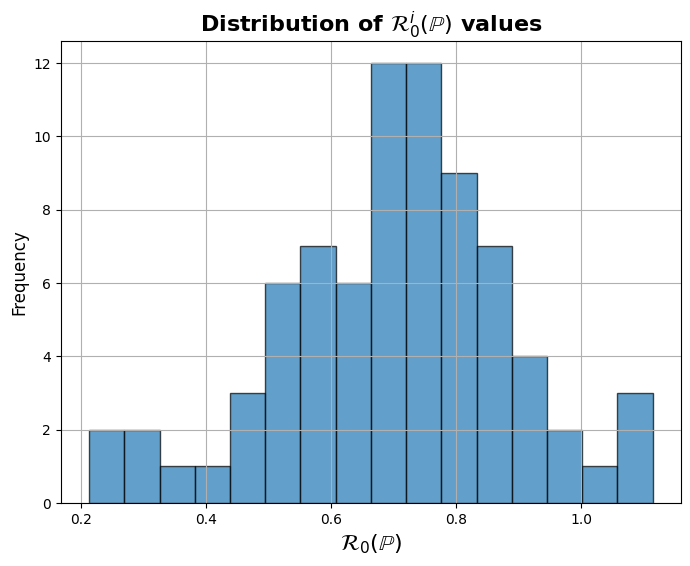

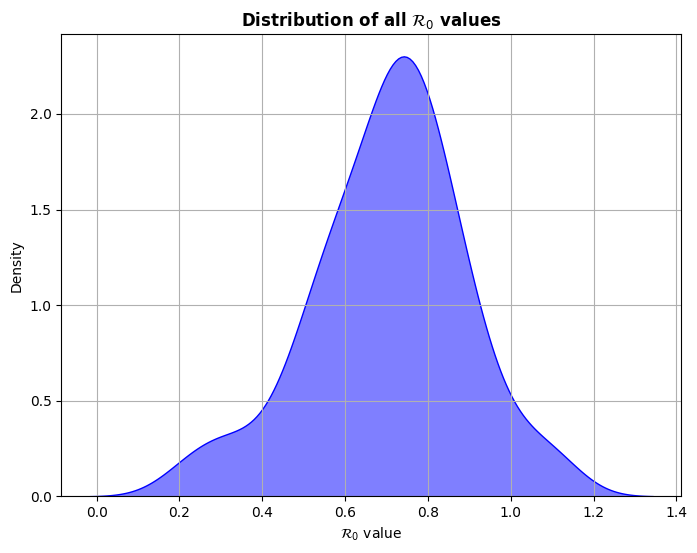

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_histogram(values, title="Histogram of $\\mathcal{R}_0(\\mathbb{P})$ Values"):
    """
    Plots a histogram of the values in the given dictionary.
    
    Parameters:
    - data_dict: dict, dictionary containing values to plot.
    - title: str, title of the plot.
    """
    
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=16, edgecolor='black', alpha=0.7)
    plt.xlabel("$\\mathcal{R}_0(\\mathbb{P})$",fontsize=16)
    plt.ylabel("Frequency",fontsize=12)
    plt.title(title, fontweight='bold',fontsize=16)
    plt.grid(True)
    plt.show()

def plot_kde(values, title="KDE of $\\mathcal{R}_0$ Values"):
    """
    Plots a Kernel Density Estimate (KDE) plot of the values in the given dictionary.
    
    Parameters:
    - data_dict: dict, dictionary containing values to plot.
    - title: str, title of the plot.
    """
    
    plt.figure(figsize=(8, 6))
    sns.kdeplot(values, fill=True, color="blue", alpha=0.5)
    plt.xlabel("$\\mathcal{R}_0$ value")
    plt.ylabel("Density")
    plt.title(title,fontweight='bold')
    plt.grid(True)
    plt.show()

# Example usage:
plot_histogram(patch_R0s, title="Distribution of $\\mathcal{R}^i_0(\\mathbb{P})$ values")
plot_kde(patch_R0s, title="Distribution of all $\\mathcal{R}_0$ values")

In [14]:
with open("ba_new_paths.pkl", 'rb') as f:
    paths = pickle.load(f)
    
import numpy as np

n = paths.shape[0]
unique_second_stations_per_row = []
station_connections = {}

for i in range(n):
    second_stations = set()
    for j in range(n):
        if i != j and paths[i, j] is not None and len(paths[i, j]) > 1:
            second_stations.add(paths[i, j][1])
    unique_second_stations_per_row.append(len(second_stations))
    station_connections[station_list[i]] = len(second_stations)

print(station_connections)

{'9 DE JULIO': 6, 'ACOYTE': 2, 'AGUERO': 2, 'ALBERTI': 2, 'ANGEL GALLARDO': 2, 'AV. DE MAYO': 4, 'AV. LA PLATA': 2, 'BELGRANO': 2, 'BOEDO': 2, 'BULNES': 2, 'CALLAO': 2, 'CALLAO - MAESTRO ALFREDO BRAVO': 2, 'CARABOBO': 2, 'CARLOS GARDEL': 2, 'CASEROS': 2, 'CASTRO BARROS': 2, 'CATALINAS': 2, 'CATEDRAL': 5, 'CONGRESO': 2, 'CONGRESO DE TUCUMAN': 1, 'CONSTITUCION': 1, 'CORDOBA': 2, 'CORRIENTES': 4, 'DE LOS INCAS PARQUE CHAS': 2, 'DORREGO': 2, 'ECHEVERRIA': 2, 'EMILIO MITRE': 2, 'ENTRE RIOS RODOLFO WALSH': 2, 'F. LACROZE': 2, 'FACULTAD DE DERECHO JULIETA LANTERI': 1, 'FACULTAD DE MEDICINA': 2, 'FLORIDA': 2, 'GENERAL SAN MARTIN': 2, 'GRAL. URQUIZA': 2, 'HOSPITALES': 1, 'INCLAN MEZQUITA AL AHMAD': 2, 'INDEPENDENCIA': 4, 'JOSE HERNANDEZ': 2, 'JOSE MARIA MORENO': 2, 'JUAN MANUEL DE ROSAS VILLA URQUIZA': 1, 'JUJUY': 4, 'JURAMENTO': 2, 'LAS HERAS': 2, 'LAVALLE': 2, 'LEANDRO N. ALEM': 3, 'LORIA': 2, 'MALABIA O. PUGLIESE': 2, 'MEDALLA MILAGROSA': 2, 'MEDRANO ALMAGRO': 2, 'MORENO': 2, 'MTRO CARRANZA 

In [15]:
full_connections = np.zeros(6084)

for i in range(6084):
    if i in home_patches:
        full_connections[i] = station_connections[station_list[list(home_patches).index(i)]]
    if i in travel_patches:
        full_connections[i] = 2

new_fc = []
for i in range(6084):
    if full_connections[i] != 0:
        new_fc.append(full_connections[i])
        
full_connections = np.array(new_fc)

connections_array = np.array(list(station_connections.values()))


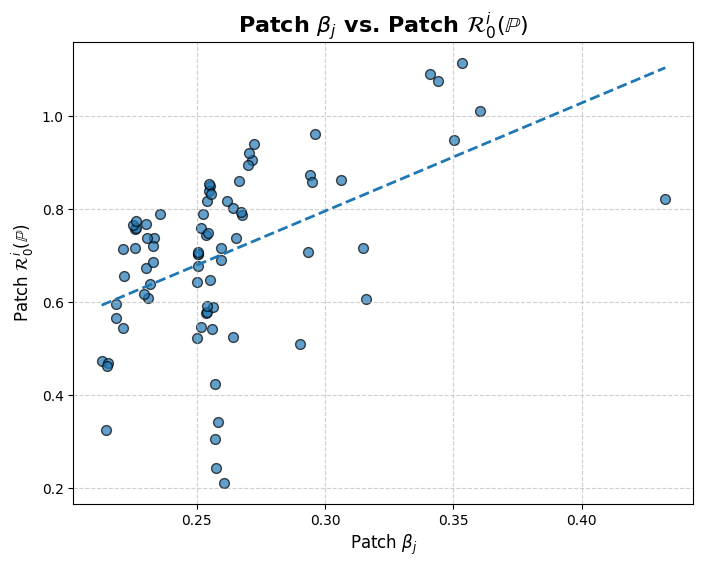

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Fit a line
coeffs = np.polyfit(home_betas, patch_R0s, deg=1)
trendline = np.poly1d(coeffs)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(home_betas, patch_R0s, s=50, alpha=0.7, edgecolors='black')
plt.plot(np.sort(home_betas), trendline(np.sort(home_betas)), linestyle='--', linewidth=2)  # Trend line

# Labels and title
plt.xlabel("Patch $\\beta_j$", fontsize=12)
plt.ylabel("Patch $\\mathcal{R}^i_0(\\mathbb{P})$", fontsize=12)
plt.title("Patch $\\beta_j$ vs. Patch $\\mathcal{R}^i_0(\\mathbb{P})$", fontsize=16, fontweight='bold')

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


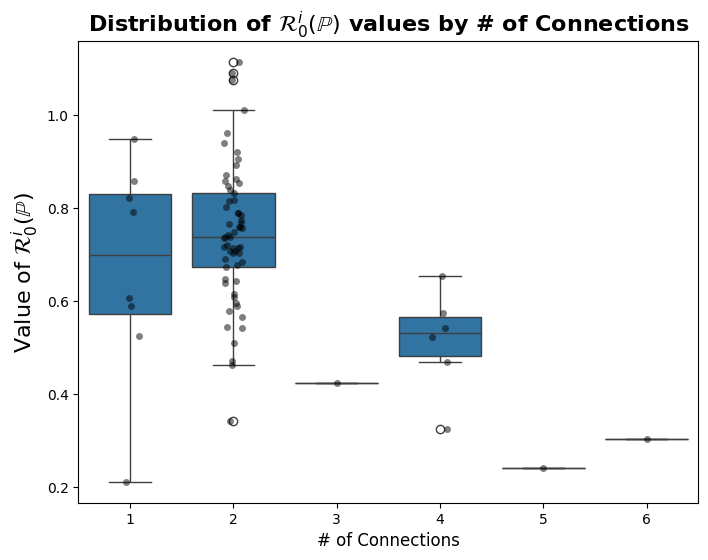

In [17]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({"Connections": connections_array, "$\\mathcal{R}^i_0(\\mathbb{P})$": patch_R0s})

plt.figure(figsize=(8,6))
sns.boxplot(x="Connections", y="$\\mathcal{R}^i_0(\\mathbb{P})$", data=df)
sns.stripplot(x="Connections", y="$\\mathcal{R}^i_0(\\mathbb{P})$", data=df, color="black", alpha=0.5, jitter=True)
plt.xlabel("# of Connections",fontsize=12)
plt.ylabel("Value of $\\mathcal{R}^i_0(\\mathbb{P})$",fontsize=16)
plt.title("Distribution of $\\mathcal{R}^i_0(\\mathbb{P})$ values by # of Connections",fontweight="bold",fontsize=16)
plt.show()


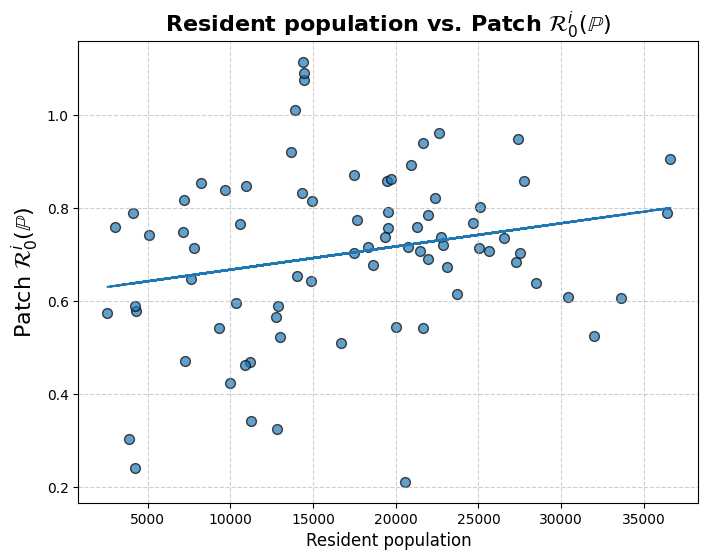

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(short_pop_vector, patch_R0s, s=50, alpha=0.7, edgecolors='black')

# Trend line
m, b = np.polyfit(short_pop_vector, patch_R0s, 1)
plt.plot(short_pop_vector, m * np.array(short_pop_vector) + b, linestyle='--')

# Labels and title
plt.xlabel("Resident population", fontsize=12)
plt.ylabel("Patch $\\mathcal{R}^i_0(\\mathbb{P})$", fontsize=16)
plt.title("Resident population vs. Patch $\\mathcal{R}^i_0(\\mathbb{P})$", fontsize=16, fontweight='bold')

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


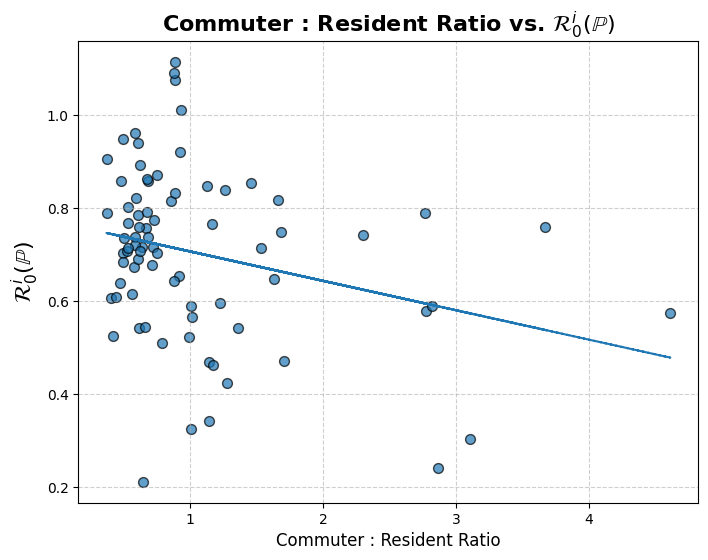

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load data
with open("Fixed Final Commuter Matrix Buenos Aires.pkl", 'rb') as file:
    p_populations = pickle.load(file)

# Calculate commuter:resident ratio
commuters_vs_residents = []
for i in range(78):
    residents = np.sum(p_populations[i])
    col_sum = np.sum(p_populations.T[i])
    commuters = col_sum - p_populations[i][i]
    commuters_vs_residents.append(commuters / residents)
commuters_vs_residents = np.array(commuters_vs_residents)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(commuters_vs_residents, patch_R0s, s=50, alpha=0.7, edgecolors='black')

# Add trend line
z = np.polyfit(commuters_vs_residents, patch_R0s, 1)
p = np.poly1d(z)
plt.plot(commuters_vs_residents, p(commuters_vs_residents), linestyle='--')

# Labels and title
plt.xlabel("Commuter : Resident Ratio", fontsize=12)
plt.ylabel(r"$\mathcal{R}^i_0(\mathbb{P})$", fontsize=16)
plt.title(r"Commuter : Resident Ratio vs. $\mathcal{R}^i_0(\mathbb{P})$", fontsize=16, fontweight='bold')

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


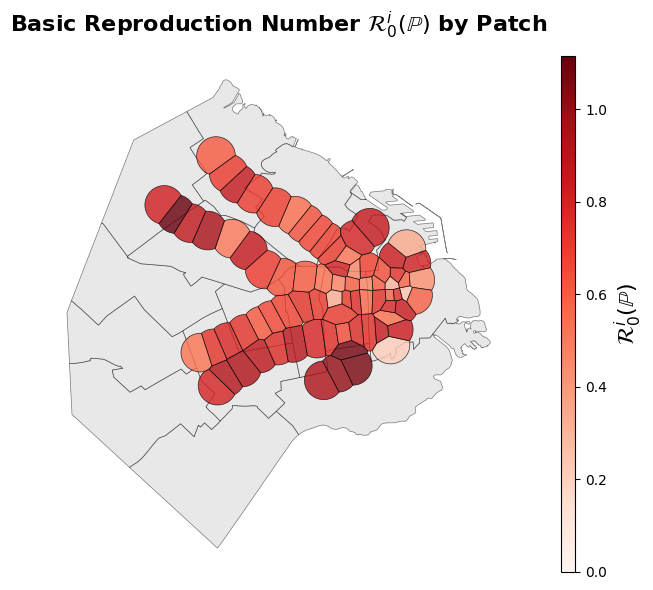

In [49]:
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.colors import LogNorm

import math
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.colors import Normalize

def plot_raw_ratio_map_ba(ratio, title="Basic Reproduction Number $\\mathcal{R}^i_0(\\mathbb{P})$ by Patch"):
    """
    Plots Voronoi patches of Buenos Aires colored by raw ratio values,
    with boroughs in the background and an adjusted colorbar.
    """
    # Load BA shapefiles
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    # Ensure CRS match
    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Add raw ratio values
    voronoi_gdf["raw_ratio"] = ratio

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    # Colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5)

    vmin = 0
    vmax = np.max(ratio)

    # Plot Voronoi patches
    voronoi_gdf.plot(
        ax=ax,
        column="raw_ratio",
        cmap="Reds",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        vmin=vmin,
        vmax=vmax
    )

    # Create colorbar manually
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label("$\\mathcal{R}^i_0(\\mathbb{P})$", fontsize=16)

    # Final touches
    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_raw_ratio_map_ba(patch_R0s)


In [19]:
home_betas.shape

(78,)

In [5]:

def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta

best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet)

In [4]:
def get_relatives(station_name):
    station_index = station_list.index(station_name)
    
    relatives = []
    for i in range(78):
        current_path = paths[station_index][i]
        if len(current_path) == 2:
            path = current_path[1]
            relatives.append(path)
            
    return relatives
            
def get_relative_indices(station_name):
    relatives = get_relatives(station_name)
    print("relatives",relatives)
    output = []
    for i in relatives:
        station1 = i[0]
        station2 = i[1]
        output.append(valid_patches.tolist().index([station1,station2]))
    return output

get_relative_indices("URUGUAY")

relatives ['9 DE JULIO', 'CALLAO - MAESTRO ALFREDO BRAVO']


ValueError: ['9', ' '] is not in list

In [9]:
p_matrix

array([[0.70493974, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00192209],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.01755866, 0.        , 0.        , ..., 0.        , 0.        ,
        0.70272193]])

In [52]:
def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas

betas = best_beta_yet

gamma = 1/5
R0_basic = betas/gamma

In [53]:
R0_basic

array([1.28529865, 1.1506945 , 1.29716185, 1.1065531 , 1.15830478,
       1.26863728, 1.357945  , 1.27623292, 1.17902782, 1.2528269 ,
       1.29789349, 1.06458085, 1.33787597, 1.10565283, 1.71972715,
       1.16753544, 1.27075011, 1.28819494, 1.09289943, 1.57993287,
       1.3027918 , 1.30964752, 1.07711839, 1.46987062, 1.47476166,
       1.7675607 , 1.34948712, 1.13022044, 1.45058496, 1.3319023 ,
       1.07531184, 1.27002209, 1.27386116, 1.13126959, 1.75043574,
       1.70360707, 1.27925897, 1.53123132, 1.15195756, 2.16299506,
       1.10890339, 1.57451392, 1.32148882, 1.26721905, 1.28544207,
       1.16486666, 1.46691539, 1.36071196, 1.15555513, 1.26198683,
       1.2522983 , 1.25193058, 1.25738247, 1.8021977 , 1.12471685,
       1.09173924, 1.13166649, 1.25763798, 1.33516144, 1.28158505,
       1.25111455, 1.07252916, 1.1463991 , 1.15293868, 1.29169936,
       1.16451127, 1.27246039, 1.27309698, 1.32709337, 1.27756026,
       1.32071466, 1.25094973, 1.25227093, 1.27625983, 1.48061

In [11]:
R0_final = np.zeros(6084)

for i in tqdm(range(6084),desc="Running"):
    sigma = 0
    
    for j in range(6084):
        second_sum = 0
        for k in range(6084):
            second_sum += p_matrix[k][j]
        sigma += p_matrix[i][j]*(betas[j]/betas[i])*(p_matrix[i][j]/second_sum)
    
    R0_final[i] = R0_basic[i]*sigma

R0_final

Running:   0%|          | 0/6084 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [7]:
R0_final.shape

()

In [ ]:
plt.scatter(Nj[travel_patches],travel_patch_R0s.values(),edgecolor="black")

In [7]:
betas[:100]

array([0.4219592 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.42481873, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.42481873, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [12]:
import numpy as np
from tqdm import tqdm

N = 6084  # Define the size

R0_final = np.zeros(N)

# Precompute second_sum for each column j
second_sum = np.sum(p_matrix, axis=0)  # Sum over k

# Avoid division by zero in second_sum
second_sum_safe = np.where(second_sum == 0, 1, second_sum)  # Replace zeros with 1

# Avoid division by zero in betas
betas_safe = np.where(betas == 0, 1, betas)  # Replace zeros with 1

# Compute sigma efficiently using matrix operations
sigma_matrix = (p_matrix * (betas_safe / betas_safe[:, np.newaxis]) * (p_matrix / second_sum_safe))

# Sum over all j
sigma = np.sum(sigma_matrix, axis=1)




In [35]:
# with open("R0_final_with_R.pkl", "wb") as f:
    # pickle.dump(R0_final, f)

In [13]:
# Compute final result
R0_final = R0_basic * sigma

In [14]:
R0_final

array([0.10007032, 0.        , 0.        , ..., 0.        , 0.        ,
       0.27136751])

In [15]:
# Assuming station_list is given
num_stations = len(station_list)

# Create dictionary with keys as pairs of station names
R0_dict = {}

# Counter to track position in R0_final
index = 0

for i in range(num_stations):
    for j in range(num_stations):
        if index < len(R0_final):
            R0_dict[(station_list[i], station_list[j])] = R0_final[index]
            index += 1
        else:
            break  # Stop if we exceed R0_final length




In [17]:
# Remove entries with value 0
all_R0_dict = {k: v for k, v in R0_dict.items() if v != 0}

# Sort dictionary by values in descending order (highest first)
sorted_items = sorted(all_R0_dict.items(), key=lambda x: x[1], reverse=True)

# Get top 10 highest values
top_10_highest = sorted_items[:10]

# Get top 10 lowest values
top_10_lowest = sorted_items[-10:]

# Output results
print("Top 10 highest values:")
for key, value in top_10_highest:
    print(f"{key}: {value}")

print("\nTop 10 lowest values:")
for key, value in top_10_lowest:
    print(f"{key}: {value}")


Top 10 highest values:
('TRIBUNALES TEATRO COLON', 'TRIBUNALES TEATRO COLON'): 0.901011194888265
('SAN JUAN', 'SAN JUAN'): 0.8382160874132661
('SAN PEDRITO', 'SAN PEDRITO'): 0.537412673020229
('RETIRO', 'CATALINAS'): 0.5232972251597754
('VARELA', 'PLAZA DE LOS VIRREYES EVA PERON'): 0.5232890540169343
('LAS HERAS', 'FACULTAD DE DERECHO JULIETA LANTERI'): 0.5232810310232147
('EMILIO MITRE', 'MEDALLA MILAGROSA'): 0.5232546390953561
('RETIRO', 'GENERAL SAN MARTIN'): 0.5232090899761124
('BOEDO', 'AV. LA PLATA'): 0.5231313304247044
('MEDALLA MILAGROSA', 'VARELA'): 0.5231146900519988

Top 10 lowest values:
('JUAN MANUEL DE ROSAS VILLA URQUIZA', 'JUAN MANUEL DE ROSAS VILLA URQUIZA'): 0.18110671247598473
('CALLAO - MAESTRO ALFREDO BRAVO', 'CALLAO - MAESTRO ALFREDO BRAVO'): 0.16944833273054233
('PALERMO', 'PALERMO'): 0.16721176625611314
('CORRIENTES', 'CORRIENTES'): 0.16304720333670386
('FACULTAD DE MEDICINA', 'FACULTAD DE MEDICINA'): 0.16177237227652047
('F. LACROZE', 'F. LACROZE'): 0.137550837

In [18]:
home_patch_R0s = {}

for i in range(78):
    current_station = station_list[i]
    home_patch_R0s[(current_station,current_station)] = all_R0_dict[(current_station,current_station)]

home_patch_R0s

{('9 DE JULIO', '9 DE JULIO'): np.float64(0.10007031693212137),
 ('ACOYTE', 'ACOYTE'): np.float64(0.22172976389679439),
 ('AGUERO', 'AGUERO'): np.float64(0.24482695995509385),
 ('ALBERTI', 'ALBERTI'): np.float64(0.2706546913163163),
 ('ANGEL GALLARDO', 'ANGEL GALLARDO'): np.float64(0.21030604694726424),
 ('AV. DE MAYO', 'AV. DE MAYO'): np.float64(0.20177200237174664),
 ('AV. LA PLATA', 'AV. LA PLATA'): np.float64(0.3190316983145237),
 ('BELGRANO', 'BELGRANO'): np.float64(0.3984241825420594),
 ('BOEDO', 'BOEDO'): np.float64(0.23381712012491854),
 ('BULNES', 'BULNES'): np.float64(0.21542578199042176),
 ('CALLAO', 'CALLAO'): np.float64(0.23584852627016956),
 ('CALLAO - MAESTRO ALFREDO BRAVO',
  'CALLAO - MAESTRO ALFREDO BRAVO'): np.float64(0.16944833273054233),
 ('CARABOBO', 'CARABOBO'): np.float64(0.2624445094152102),
 ('CARLOS GARDEL', 'CARLOS GARDEL'): np.float64(0.18684778341698516),
 ('CASEROS', 'CASEROS'): np.float64(0.2802834722012415),
 ('CASTRO BARROS', 'CASTRO BARROS'): np.float

In [19]:
travel_patch_R0s = {}

for patch in list(all_R0_dict.keys()):
    if patch not in list(home_patch_R0s.keys()):
        travel_patch_R0s[patch] = all_R0_dict[patch]
        
travel_patch_R0s

{('9 DE JULIO', 'AV. DE MAYO'): np.float64(0.521693430354836),
 ('9 DE JULIO', 'CATEDRAL'): np.float64(0.5210073053447202),
 ('9 DE JULIO', 'FLORIDA'): np.float64(0.5218334545728411),
 ('9 DE JULIO', 'LAVALLE'): np.float64(0.5215260970153908),
 ('9 DE JULIO', 'TRIBUNALES TEATRO COLON'): np.float64(0.5213588904852363),
 ('9 DE JULIO', 'URUGUAY'): np.float64(0.5215270141614433),
 ('ACOYTE', 'PRIMERA JUNTA'): np.float64(0.5211584984949182),
 ('ACOYTE', 'RIO DE JANEIRO'): np.float64(0.5198623259235339),
 ('AGUERO', 'BULNES'): np.float64(0.5210078864192078),
 ('AGUERO', 'SANTA FE CARLOS JAUREGUI'): np.float64(0.5179340013401523),
 ('ALBERTI', 'PASCO'): np.float64(0.5215694885404344),
 ('ALBERTI', 'PLAZA MISERERE'): np.float64(0.5223916800603454),
 ('ANGEL GALLARDO', 'MALABIA O. PUGLIESE'): np.float64(0.5214475310425036),
 ('ANGEL GALLARDO', 'MEDRANO ALMAGRO'): np.float64(0.5188638161559121),
 ('AV. DE MAYO', '9 DE JULIO'): np.float64(0.5215714211477085),
 ('AV. DE MAYO', 'MORENO'): np.float

In [20]:
valid_patch_indices

array([   0,    5,   17,   31,   43,   73,   75,   79,  140,  143,  158,
        165,  227,  237,  288,  295,  316,  358,  360,  390,  395,  439,
        447,  456,  474,  476,  506,  553,  563,  582,  630,  632,  657,
        704,  711,  774,  790,  810,  853,  869,  913,  933,  948,  999,
       1004, 1027, 1036, 1062, 1106, 1127, 1145, 1185, 1215, 1235, 1264,
       1292, 1312, 1326, 1333, 1343, 1370, 1383, 1385, 1422, 1458, 1470,
       1501, 1523, 1580, 1629, 1659, 1660, 1709, 1729, 1737, 1738, 1771,
       1777, 1817, 1819, 1868, 1896, 1900, 1918, 1973, 1975, 1989, 2054,
       2066, 2075, 2133, 2162, 2173, 2208, 2212, 2258, 2291, 2304, 2350,
       2370, 2411, 2418, 2449, 2462, 2528, 2539, 2560, 2582, 2607, 2614,
       2686, 2705, 2744, 2765, 2770, 2815, 2844, 2857, 2875, 2877, 2923,
       2927, 2937, 2970, 2990, 3002, 3067, 3081, 3153, 3155, 3160, 3176,
       3197, 3217, 3235, 3239, 3305, 3318, 3347, 3354, 3386, 3397, 3448,
       3449, 3463, 3476, 3525, 3555, 3571, 3592, 36

In [26]:
pairs_list = []
for i in range(78):
    for j in range(78):
        pairs_list.append((station_list[i],station_list[j]))
        
pairs_list

[('9 DE JULIO', '9 DE JULIO'),
 ('9 DE JULIO', 'ACOYTE'),
 ('9 DE JULIO', 'AGUERO'),
 ('9 DE JULIO', 'ALBERTI'),
 ('9 DE JULIO', 'ANGEL GALLARDO'),
 ('9 DE JULIO', 'AV. DE MAYO'),
 ('9 DE JULIO', 'AV. LA PLATA'),
 ('9 DE JULIO', 'BELGRANO'),
 ('9 DE JULIO', 'BOEDO'),
 ('9 DE JULIO', 'BULNES'),
 ('9 DE JULIO', 'CALLAO'),
 ('9 DE JULIO', 'CALLAO - MAESTRO ALFREDO BRAVO'),
 ('9 DE JULIO', 'CARABOBO'),
 ('9 DE JULIO', 'CARLOS GARDEL'),
 ('9 DE JULIO', 'CASEROS'),
 ('9 DE JULIO', 'CASTRO BARROS'),
 ('9 DE JULIO', 'CATALINAS'),
 ('9 DE JULIO', 'CATEDRAL'),
 ('9 DE JULIO', 'CONGRESO'),
 ('9 DE JULIO', 'CONGRESO DE TUCUMAN'),
 ('9 DE JULIO', 'CONSTITUCION'),
 ('9 DE JULIO', 'CORDOBA'),
 ('9 DE JULIO', 'CORRIENTES'),
 ('9 DE JULIO', 'DE LOS INCAS PARQUE CHAS'),
 ('9 DE JULIO', 'DORREGO'),
 ('9 DE JULIO', 'ECHEVERRIA'),
 ('9 DE JULIO', 'EMILIO MITRE'),
 ('9 DE JULIO', 'ENTRE RIOS RODOLFO WALSH'),
 ('9 DE JULIO', 'F. LACROZE'),
 ('9 DE JULIO', 'FACULTAD DE DERECHO JULIETA LANTERI'),
 ('9 DE JULIO

In [27]:
len(pairs_list)

6084

In [35]:
valid_pairs = np.array(pairs_list)[travel_patches]

In [36]:
valid_pairs.shape

(168, 2)

In [38]:
station_connections = {}

for i in range(168):
    station1 = valid_pairs[i][0]
    if station1 in list(station_connections.keys()):
        station_connections[station1] += 1
    else:
        station_connections[station1] = 1

In [39]:
station_connections

{np.str_('9 DE JULIO'): 6,
 np.str_('ACOYTE'): 2,
 np.str_('AGUERO'): 2,
 np.str_('ALBERTI'): 2,
 np.str_('ANGEL GALLARDO'): 2,
 np.str_('AV. DE MAYO'): 4,
 np.str_('AV. LA PLATA'): 2,
 np.str_('BELGRANO'): 2,
 np.str_('BOEDO'): 2,
 np.str_('BULNES'): 2,
 np.str_('CALLAO'): 2,
 np.str_('CALLAO - MAESTRO ALFREDO BRAVO'): 2,
 np.str_('CARABOBO'): 2,
 np.str_('CARLOS GARDEL'): 2,
 np.str_('CASEROS'): 2,
 np.str_('CASTRO BARROS'): 2,
 np.str_('CATALINAS'): 2,
 np.str_('CATEDRAL'): 5,
 np.str_('CONGRESO'): 2,
 np.str_('CONGRESO DE TUCUMAN'): 1,
 np.str_('CONSTITUCION'): 1,
 np.str_('CORDOBA'): 2,
 np.str_('CORRIENTES'): 4,
 np.str_('DE LOS INCAS PARQUE CHAS'): 2,
 np.str_('DORREGO'): 2,
 np.str_('ECHEVERRIA'): 2,
 np.str_('EMILIO MITRE'): 2,
 np.str_('ENTRE RIOS RODOLFO WALSH'): 2,
 np.str_('F. LACROZE'): 2,
 np.str_('FACULTAD DE DERECHO JULIETA LANTERI'): 1,
 np.str_('FACULTAD DE MEDICINA'): 2,
 np.str_('FLORIDA'): 2,
 np.str_('GENERAL SAN MARTIN'): 2,
 np.str_('GRAL. URQUIZA'): 2,
 np.str

In [40]:
full_connections = np.zeros(6084)

for i in range(6084):
    if i in home_patches:
        full_connections[i] = station_connections[station_list[list(home_patches).index(i)]]
    if i in travel_patches:
        full_connections[i] = 2

new_fc = []
for i in range(6084):
    if full_connections[i] != 0:
        new_fc.append(full_connections[i])
        
full_connections = np.array(new_fc)

In [26]:
np.median(full_connections),np.average(full_connections)

(np.float64(2.0), np.float64(2.100358422939068))

In [23]:
full_connections

array([4., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 6., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 7., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 5.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2.,
       2., 4., 2., 2., 2.

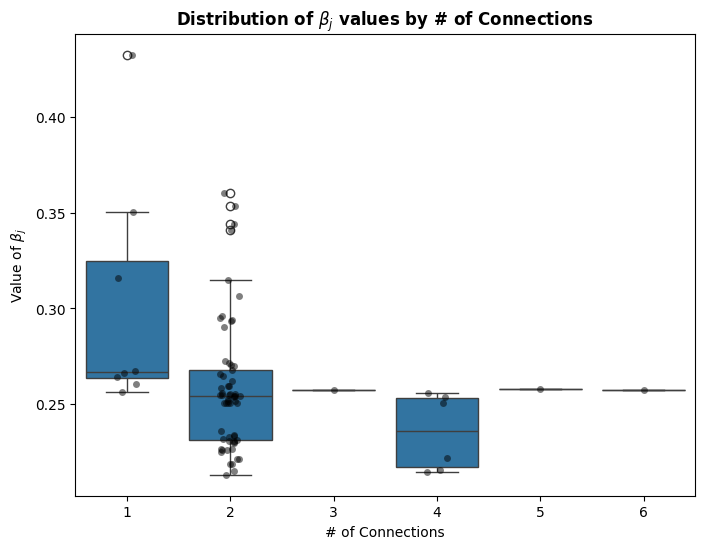

In [18]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({"Connections": connections_array, "Beta": home_betas})

plt.figure(figsize=(8,6))
sns.boxplot(x="Connections", y="Beta", data=df)
sns.stripplot(x="Connections", y="Beta", data=df, color="black", alpha=0.5, jitter=True)
plt.xlabel("# of Connections")
plt.ylabel("Value of $\\beta_j$")
plt.title("Distribution of $\\beta_j$ values by # of Connections",fontweight="bold")
plt.show()


In [41]:
connections_array = np.array(list(station_connections.values()))
home_R0_array = np.array(list(home_patch_R0s.values()))


NameError: name 'home_patch_R0s' is not defined

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Jitter function
def add_jitter(arr, scale=0.1):
    return arr + np.random.uniform(-scale, scale, arr.shape)

jittered_connections = add_jitter(connections_array)

plt.scatter(jittered_connections, home_R0_array, alpha=0.7)
plt.xlabel("Station Connectivity")
plt.ylabel("R0 Value")
plt.title("Correlation Between Station Connectivity and R0")
plt.show()


NameError: name 'home_R0_array' is not defined

In [43]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({"Connections": connections_array, "R0": home_R0_array})

plt.figure(figsize=(8,6))
sns.boxplot(x="Connections", y="R0", data=df)
sns.stripplot(x="Connections", y="R0", data=df, color="black", alpha=0.5, jitter=True)
plt.xlabel("Station Connectivity")
plt.ylabel("R0 Value")
plt.title("R0 Distribution by Connectivity Level")
plt.show()


NameError: name 'home_R0_array' is not defined

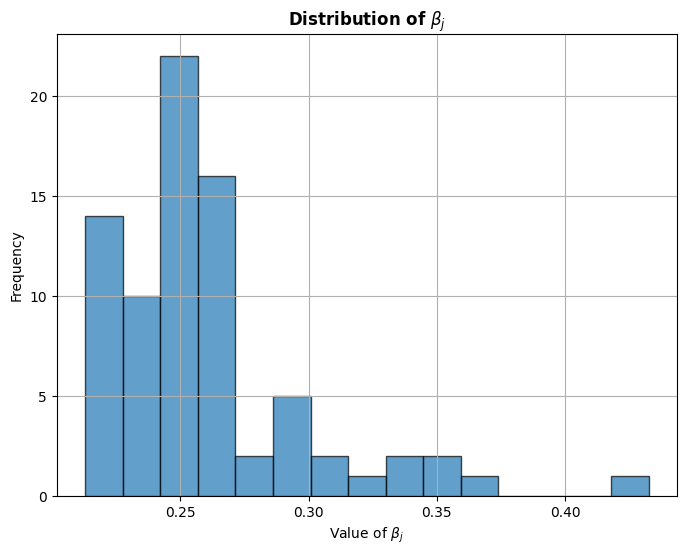

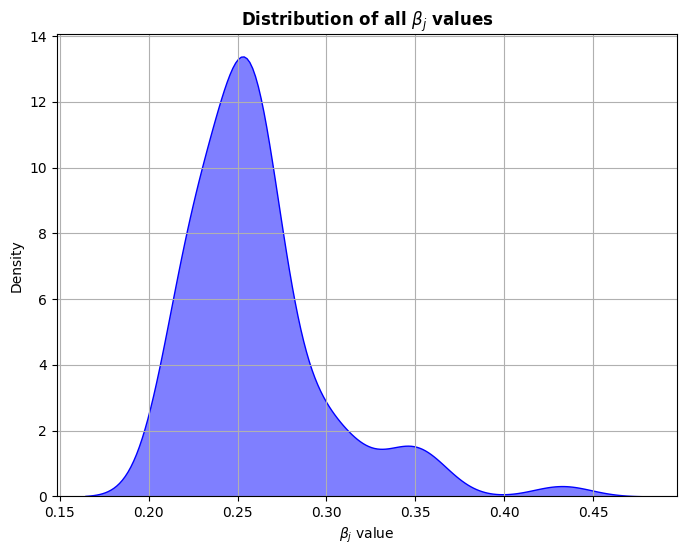

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_histogram(values, title="Histogram of Beta Values"):
    """
    Plots a histogram of the values in the given dictionary.
    
    Parameters:
    - data_dict: dict, dictionary containing values to plot.
    - title: str, title of the plot.
    """
    
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=15, edgecolor='black', alpha=0.7)
    plt.xlabel("Value of $\\beta_j$")
    plt.ylabel("Frequency")
    plt.title(title, fontweight='bold')
    plt.grid(True)
    plt.show()

def plot_kde(values, title="KDE of Beta Values"):
    """
    Plots a Kernel Density Estimate (KDE) plot of the values in the given dictionary.
    
    Parameters:
    - data_dict: dict, dictionary containing values to plot.
    - title: str, title of the plot.
    """
    
    plt.figure(figsize=(8, 6))
    sns.kdeplot(values, fill=True, color="blue", alpha=0.5)
    plt.xlabel("$\\beta_j$ value")
    plt.ylabel("Density")
    plt.title(title,fontweight='bold')
    plt.grid(True)
    plt.show()

# Example usage:
plot_histogram(home_betas, title="Distribution of $\\beta_j$")
plot_kde(home_betas, title="Distribution of all $\\beta_j$ values")

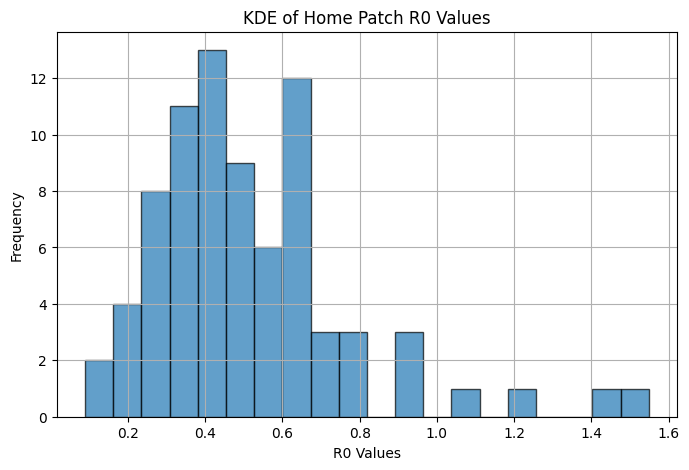

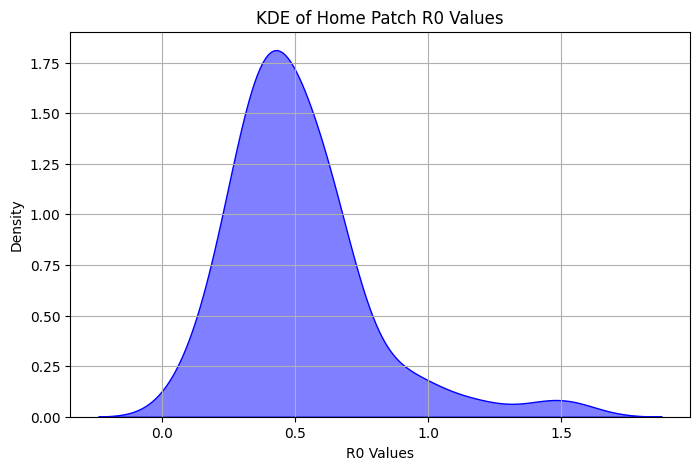

In [46]:
plot_histogram(home_patch_R0s, title="KDE of Home Patch R0 Values")
plot_kde(home_patch_R0s, title="KDE of Home Patch R0 Values")

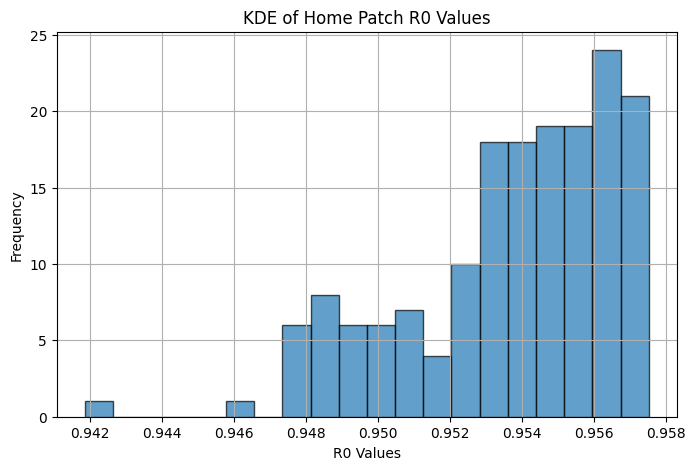

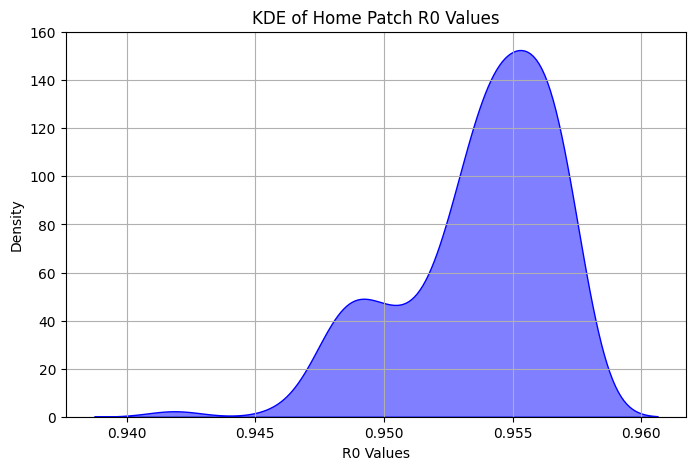

In [47]:
plot_histogram(travel_patch_R0s, title="KDE of Home Patch R0 Values")
plot_kde(travel_patch_R0s, title="KDE of Home Patch R0 Values")

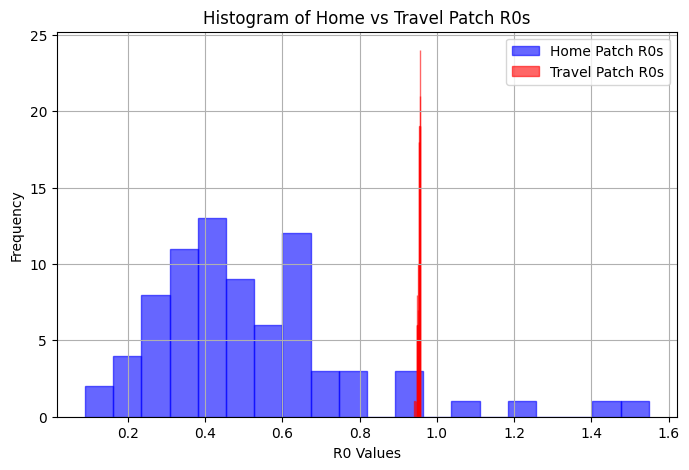

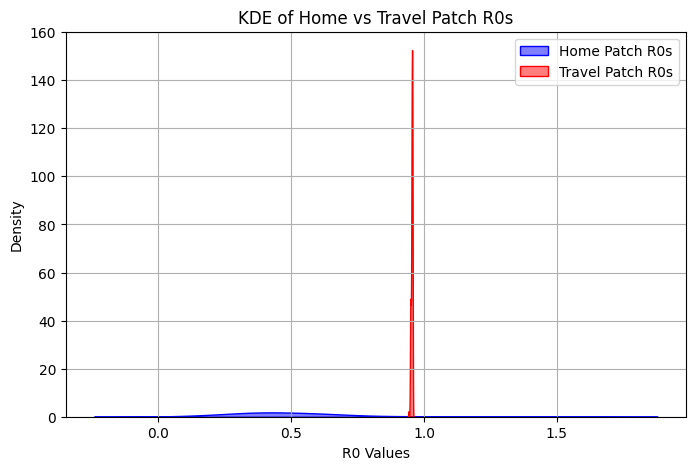

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_overlayed_histogram(home_dict, travel_dict, title="Overlayed Histogram of R0 Values"):
    """
    Plots an overlayed histogram of the values in the two given dictionaries.
    
    Parameters:
    - home_dict: dict, dictionary containing first dataset.
    - travel_dict: dict, dictionary containing second dataset.
    - title: str, title of the plot.
    """
    home_values = list(home_dict.values())
    travel_values = list(travel_dict.values())

    plt.figure(figsize=(8, 5))
    plt.hist(home_values, bins=20, alpha=0.6, color='blue', label="Home Patch R0s", edgecolor="blue")
    plt.hist(travel_values, bins=20, alpha=0.6, color='red', label="Travel Patch R0s", edgecolor="red")
    
    plt.xlabel("R0 Values")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_overlayed_kde(home_dict, travel_dict, title="Overlayed KDE of R0 Values"):
    """
    Plots an overlayed KDE plot of the values in the two given dictionaries.
    
    Parameters:
    - home_dict: dict, dictionary containing first dataset.
    - travel_dict: dict, dictionary containing second dataset.
    - title: str, title of the plot.
    """
    home_values = np.array(list(home_dict.values()))
    travel_values = np.array(list(travel_dict.values()))

    plt.figure(figsize=(8, 5))
    sns.kdeplot(home_values, fill=True, alpha=0.5, color="blue", label="Home Patch R0s")
    sns.kdeplot(travel_values, fill=True, alpha=0.5, color="red", label="Travel Patch R0s")

    plt.xlabel("R0 Values")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
plot_overlayed_histogram(home_patch_R0s, travel_patch_R0s, title="Histogram of Home vs Travel Patch R0s")
plot_overlayed_kde(home_patch_R0s, travel_patch_R0s, title="KDE of Home vs Travel Patch R0s")


In [49]:
import numpy as np
import pandas as pd

def compute_summary_statistics(data_dict):
    """
    Computes and prints summary statistics for a given dictionary.
    
    Parameters:
    - data_dict: dict, dictionary containing numerical values.
    
    Returns:
    - A dictionary with computed statistics.
    """
    values = np.array(list(data_dict.values()))
    
    summary_stats = {
        "Count": len(values),
        "Mean": np.mean(values),
        "Median": np.median(values),
        "Standard Deviation": np.std(values, ddof=1),
        "Minimum": np.min(values),
        "Maximum": np.max(values),
        "25th Percentile (Q1)": np.percentile(values, 25),
        "75th Percentile (Q3)": np.percentile(values, 75),
        "Interquartile Range (IQR)": np.percentile(values, 75) - np.percentile(values, 25)
    }

    return summary_stats

# Compute statistics for all three datasets
home_stats = compute_summary_statistics(home_patch_R0s)
travel_stats = compute_summary_statistics(travel_patch_R0s)
filtered_stats = compute_summary_statistics(all_R0_dict)

# Convert to a DataFrame for better visualization
stats_df = pd.DataFrame([home_stats, travel_stats, filtered_stats], 
                        index=["Home Patch R0s", "Travel Patch R0s", "Filtered R0 Dict"])

stats_df

,Count,Mean,Median,Standard Deviation,Minimum,Maximum,25th Percentile (Q1),75th Percentile (Q3),Interquartile Range (IQR)
Home Patch R0s,78,0.511421,0.468284,0.263106,0.089365,1.548272,0.346269,0.615808,0.269539
Travel Patch R0s,168,0.953732,0.954365,0.002907,0.941859,0.957510,0.952356,0.955983,0.003627
Filtered R0 Dict,246,0.813487,0.952840,0.253571,0.089365,1.548272,0.632852,0.955455,0.322603


In [53]:
len(list(travel_patch_R0s.keys()))

168

In [55]:
R0s_vs_travel_times = np.zeros([168,2])

for i in range(168):
    patch = list(travel_patch_R0s.keys())[i]
    R0s_vs_travel_times[i][0] = travel_times[patch]
    R0s_vs_travel_times[i][1] = travel_patch_R0s[patch]
    
R0s_vs_travel_times

array([[1.        , 0.95457532],
       [2.        , 0.95331988],
       [2.        , 0.95483153],
       [2.        , 0.95426914],
       [1.        , 0.95396319],
       [1.        , 0.95427082],
       [2.        , 0.95359652],
       [2.        , 0.95122484],
       [1.        , 0.95332094],
       [2.        , 0.94769646],
       [1.        , 0.95434854],
       [1.        , 0.95585295],
       [1.        , 0.95412538],
       [2.        , 0.9493978 ],
       [1.        , 0.95435207],
       [2.        , 0.95084288],
       [1.        , 0.95567491],
       [1.        , 0.95601907],
       [1.        , 0.95427776],
       [2.        , 0.95682597],
       [1.        , 0.95401525],
       [2.        , 0.95623962],
       [1.        , 0.95720634],
       [2.        , 0.94970652],
       [1.        , 0.95313089],
       [2.        , 0.94941409],
       [1.        , 0.9542847 ],
       [2.        , 0.94798394],
       [2.        , 0.95170736],
       [1.        , 0.9525893 ],
       [2.

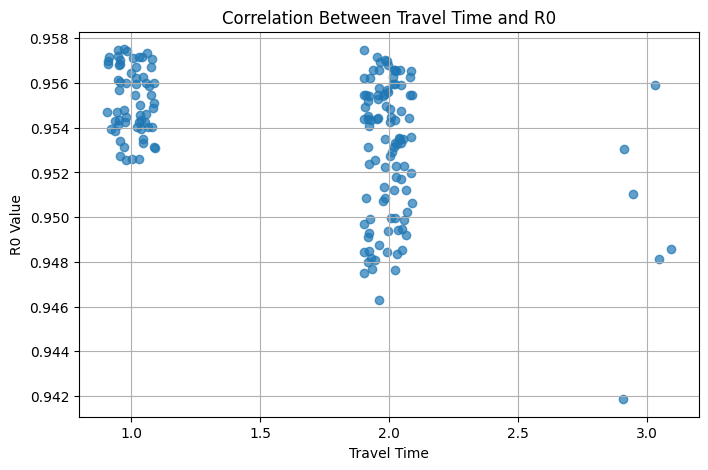

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Jitter function
def add_jitter(arr, scale=0.1):
    return arr + np.random.uniform(-scale, scale, arr.shape)

# Extracting R0 values and travel times
travel_times = R0s_vs_travel_times[:, 0]  # First column (X-axis)
R0_values = R0s_vs_travel_times[:, 1]     # Second column (Y-axis)

# Add jitter to travel times
jittered_travel_times = add_jitter(travel_times, scale=0.1)

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(jittered_travel_times, R0_values, alpha=0.7)
plt.xlabel("Travel Time")
plt.ylabel("R0 Value")
plt.title("Correlation Between Travel Time and R0")
plt.grid(True)
plt.show()


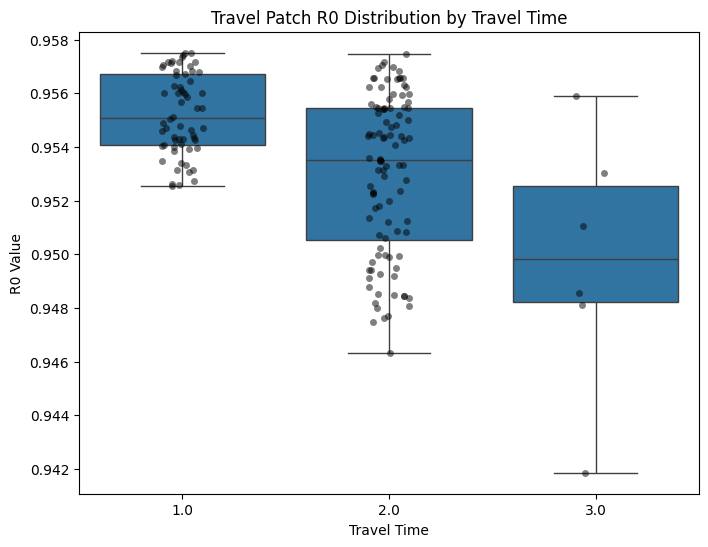

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert array to DataFrame
df = pd.DataFrame({
    "Travel Time": R0s_vs_travel_times[:, 0],  # First column (connectivity levels)
    "R0": R0s_vs_travel_times[:, 1]           # Second column (R0 values)
})

# Create the plot
plt.figure(figsize=(8,6))
sns.boxplot(x="Travel Time", y="R0", data=df)
sns.stripplot(x="Travel Time", y="R0", data=df, color="black", alpha=0.5, jitter=True)
plt.xlabel("Travel Time")
plt.ylabel("R0 Value")
plt.title("Travel Patch R0 Distribution by Travel Time")
plt.show()


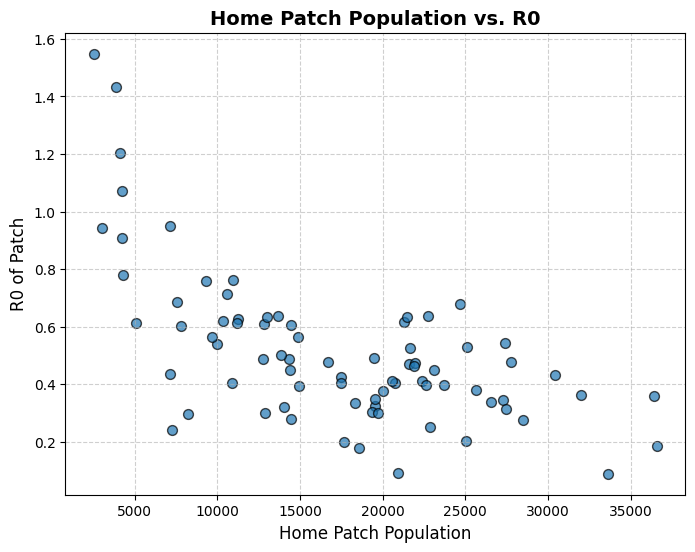

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(short_pop_vector, list(home_patch_R0s.values()), s=50, alpha=0.7, edgecolors='black')

# Labels and title
plt.xlabel("Home Patch Population", fontsize=12)
plt.ylabel("R0 of Patch", fontsize=12)
plt.title("Home Patch Population vs. R0", fontsize=14, fontweight='bold')

# Grid and layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()


In [59]:
alphas = np.ones(6084)*(1/5)


def making_NGM(p_matrix,N_array,betas,alphas):
    size = betas.shape[0]  # 6084 for full London system
    NGM = np.zeros([size,size])
    for i in range(size):
        for j in range(size):
            N_div_a = N_array[i]/alphas[j]
            k_sum = 0
            for k in range(size):
                l_sum = 0
                for l in range(size):
                    l_sum += N_array[l]*p_matrix[l][k]
                
                k_sum += betas[k]*p_matrix[i][k]*p_matrix[j][k]/l_sum
            NGM[i][j] = k_sum*N_div_a
    return NGM

In [6]:
gammas = np.ones(6084)*(1/5)

import numpy as np
from scipy.sparse import csr_matrix
from tqdm import tqdm

def making_NGM(sparse_p, N_array, betas, gammas):
    size = betas.shape[0]  

    print("Computing l_sums...")
    l_sums = sparse_p.T.dot(N_array)  # Efficient matrix-vector multiplication
    l_sums[l_sums == 0] = 1  # Avoid division by zero

    print("Computing k_sums...")
    k_sums = csr_matrix((size, size))  # Initialize sparse result matrix

    # Iterate over nonzero elements of sparse_p
    for k in tqdm(range(size), desc="Processing k_sums"):
        if l_sums[k] == 0:  # Skip empty columns
            continue
        k_sums += sparse_p[:, k].dot((betas[k] * sparse_p[:, k].T / l_sums[k]))

    print("Finalizing NGM computation...")
    NGM = (N_array[:, None] / gammas) * k_sums.toarray()  # Convert to dense if necessary

    print("NGM computation complete.")
    return NGM


In [7]:
ngm_beta = np.zeros(6084)
ngm_beta[home_patches] = best_beta_yet[:78]
ngm_beta[travel_patches] = best_beta_yet[-1]

ngm_beta.shape

(6084,)

In [8]:
NGM = making_NGM(sparse_p,pop_vector,ngm_beta,gammas)
NGM

Computing l_sums...
Computing k_sums...


Processing k_sums: 100%|██████████| 6084/6084 [00:03<00:00, 1804.04it/s]


Finalizing NGM computation...
NGM computation complete.


array([[0.09915001, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00317444],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02043371, 0.        , 0.        , ..., 0.        , 0.        ,
        0.73832016]])

In [11]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# Ensure NGM is stored efficiently in CSR format
NGM_sparse = csr_matrix(NGM)

# Compute only the largest 78 eigenvalues using shift-invert mode
eigenvalues, eigenvectors = eigs(NGM_sparse, k=1, which="LM", tol=1e-6)

print("Computed Top Eigenvalue:", eigenvalues)
top_eig = eigenvalues[0]

Computed Top Eigenvalue: [1.35300862+0.j]


/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


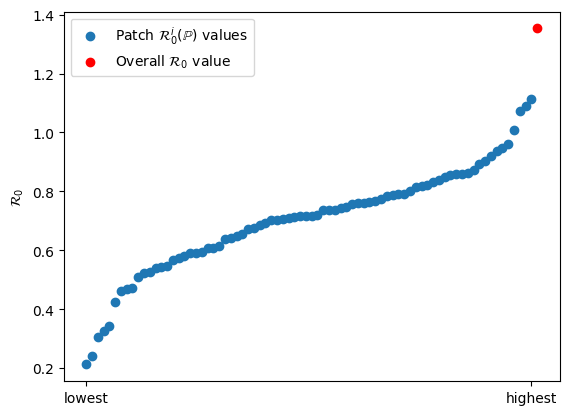

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Sort R0s
sorted_indices = np.argsort(patch_R0s)
sorted_R0s = patch_R0s[sorted_indices]

# Find position of top_eig in sorted list
insert_pos = np.searchsorted(sorted_R0s, top_eig)

# Plot
plt.scatter(range(len(sorted_R0s)), sorted_R0s, label='Patch $\\mathcal{R}_0^i(\\mathbb{P})$ values')
plt.scatter(insert_pos, top_eig, color='red', label='Overall $\\mathcal{R}_0$ value')

# Customize x-axis
plt.xticks([0, len(sorted_R0s) - 1], ['lowest', 'highest'])
plt.xlabel('')
plt.ylabel('$\\mathcal{R}_0$')
plt.legend()
plt.show()


In [51]:
print("Computed Top Eigenvalue:", eigenvalues)

Computed Top Eigenvalue: [2.04104273+0.j]
